In [2]:
import geopandas as gpd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier

def load_and_preprocess_data(geology_file, mineral_file):
    # Load shapefiles
    gdf_geological = gpd.read_file(geology_file)
    gdf_mineral = gpd.read_file(mineral_file)

    # Data preprocessing
    gdf_geological = gdf_geological.dropna()
    gdf_mineral = gdf_mineral.dropna()

    # Set and transform CRS
    gdf_geological.set_crs(epsg=4326, inplace=True)
    gdf_mineral.set_crs(epsg=4326, inplace=True)
    gdf_geological = gdf_geological.to_crs('EPSG:4326')
    gdf_mineral = gdf_mineral.to_crs('EPSG:4326')

    # Compute geometric properties
    gdf_geological['area'] = gdf_geological.geometry.area
    gdf_geological['perimeter'] = gdf_geological.geometry.length

    # Spatial join
    gdf_joined = gpd.sjoin(gdf_mineral, gdf_geological, how="inner", op='within')
    gdf_geological['has_minerals'] = gdf_geological.index.isin(gdf_joined.index).astype(int)

    return gdf_geological

def prepare_features(gdf):
    X = gdf[['area', 'perimeter']]
    y = gdf['has_minerals']
    return X, y

def load_pretrained_model(model_file):
    with open(model_file, 'rb') as file:
        model = pickle.load(file)
    return model

def fine_tune_model(model, X_train, y_train, X_test, y_test):
    # Fine-tune the model on new data
    model.fit(X_train, y_train)

    # Evaluate the fine-tuned model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Fine-tuned model performance:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    return model

def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

# Main process
def fine_tune_for_new_state(state_name, geology_file, mineral_file, pretrained_model_file):
    # Load and preprocess data for the new state
    gdf_new_state = load_and_preprocess_data(geology_file, mineral_file)

    # Prepare features
    X, y = prepare_features(gdf_new_state)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Load the pre-trained model
    pretrained_model = load_pretrained_model(pretrained_model_file)

    # Fine-tune the model
    fine_tuned_model = fine_tune_model(pretrained_model, X_train, y_train, X_test, y_test)

    # Save the fine-tuned model
    save_model(fine_tuned_model, f'{state_name}_mineral_model.pkl')

    print(f"Fine-tuned model for {state_name} has been saved.")

# Usage
pretrained_model_file = '/content/drive/MyDrive/NFC/Maharashta/xgboost_mineral_prediction_model.pkl'  # Your Maharashtra model
new_state_name = 'Arunachal'  # Replace with the name of the new state
new_state_geology_file = '/content/drive/MyDrive/NFC/Arunachal pradesh/Geology 2M.shp'  # Replace with actual file path
new_state_mineral_file = '/content/drive/MyDrive/NFC/Arunachal pradesh/Mineralization.shp'  # Replace with actual file path

fine_tune_for_new_state(new_state_name, new_state_geology_file, new_state_mineral_file, pretrained_model_file)

<ipython-input-2-0678b9ec9d25>:23: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_geological['area'] = gdf_geological.geometry.area
<ipython-input-2-0678b9ec9d25>:24: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_geological['perimeter'] = gdf_geological.geometry.length
<ipython-input-2-0678b9ec9d25>:93: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  fine_tune_for_new_state(new_state_name, new_state_geology_file, new_state_mineral_file, pretrained_model_file)


Fine-tuned model performance:
Accuracy: 0.5925925925925926
Precision: 0.6428571428571429
Recall: 0.6
F1 Score: 0.6206896551724138
Fine-tuned model for Arunachal has been saved.


In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

def load_and_preprocess_data(states):
    combined_data = pd.DataFrame()
    for state in states:
        geological_file = f"/content/drive/MyDrive/NFC/{state}/Geology 2M.shp"
        mineral_file = f"/content/drive/MyDrive/NFC/{state}/Mineralization.shp"

        gdf_geological = gpd.read_file(geological_file)
        gdf_mineral = gpd.read_file(mineral_file)

        gdf_geological = gdf_geological.dropna()
        gdf_mineral = gdf_mineral.dropna()

        gdf_geological.set_crs(epsg=4326, inplace=True)
        gdf_mineral.set_crs(epsg=4326, inplace=True)
        gdf_geological = gdf_geological.to_crs('EPSG:4326')
        gdf_mineral = gdf_mineral.to_crs('EPSG:4326')

        gdf_geological['area'] = gdf_geological.geometry.area
        gdf_geological['perimeter'] = gdf_geological.geometry.length

        gdf_joined = gpd.sjoin(gdf_mineral, gdf_geological, how="inner", op='within')
        gdf_geological['has_minerals'] = gdf_geological.index.isin(gdf_joined.index).astype(int)

        gdf_geological['state'] = state
        combined_data = pd.concat([combined_data, gdf_geological], ignore_index=True)

    return combined_data

def feature_engineering(data):
    data['area_to_perimeter_ratio'] = data['area'] / data['perimeter']
    data['log_area'] = np.log1p(data['area'])
    data['log_perimeter'] = np.log1p(data['perimeter'])
    data['shape_factor'] = 4 * np.pi * data['area'] / (data['perimeter'] ** 2)

    # Add more features based on geological attributes if available
    # For example: data['rock_type_encoded'] = pd.get_dummies(data['rock_type'])

    return data

def train_and_evaluate_model(X_train, X_test, y_train, y_test, model_type='xgboost'):
    if model_type == 'xgboost':
        model = XGBClassifier(random_state=42)
        param_grid = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.3],
            'max_depth': [3, 5, 7]
        }
    elif model_type == 'random_forest':
        model = RandomForestClassifier(random_state=42)
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [5, 10, None],
            'min_samples_split': [2, 5, 10]
        }
    elif model_type == 'lightgbm':
        model = LGBMClassifier(random_state=42)
        param_grid = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.3],
            'num_leaves': [31, 63, 127]
        }
    elif model_type == 'hist_gradient_boosting':
        model = HistGradientBoostingClassifier(random_state=42)
        param_grid = {
            'max_iter': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.3],
            'max_depth': [3, 5, 7]
        }
    elif model_type == 'logistic_regression':
        model = LogisticRegression(random_state=42)
        param_grid = {
            'C': [0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        }

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n{model_type.upper()} Results:")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return best_model, accuracy

# Load and preprocess data for all states
states = ["Maharashta", "Arunachal pradesh", "Assam","Andhrapradesh","Bihar","Chandigarh","Chhattisgarh","Goa","Gujrat","Haryana","Himachal Pradesh","Jammu and Kashmir","Jharkhand","Karnataka","Ladakh","Madhya Pradesh","Manipur","Meghalaya","Mizoram","Nagaland","Odisha","Puducherry","Punjab","Rajasthan","Sikkim","Tamil Nadu","Telangana","Tripura","Uttar Pradesh","Uttarakhand","West Bengal"]  # Replace with actual state names
combined_data = load_and_preprocess_data(states)

# Feature engineering
combined_data = feature_engineering(combined_data)

# Prepare features and target
X = combined_data[['area', 'perimeter', 'area_to_perimeter_ratio', 'log_area', 'log_perimeter', 'shape_factor']]
y = combined_data['has_minerals']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Train and evaluate models
models = [
    'xgboost',
    'random_forest',
    'lightgbm',
    'hist_gradient_boosting',
    'logistic_regression'
]

best_model = None
best_accuracy = 0
best_model_name = ''

for model_type in models:
    model, accuracy = train_and_evaluate_model(X_train, X_test, y_train, y_test, model_type=model_type)
    if accuracy > best_accuracy:
        best_model = model
        best_accuracy = accuracy
        best_model_name = model_type

print(f"\nBest Model: {best_model_name}")
print(f"Best Accuracy: {best_accuracy:.4f}")

# Feature importance for the best performing model (except for logistic regression)
if best_model_name != 'logistic_regression':
    feature_importance = best_model.feature_importances_
    feature_names = X.columns

    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importance, y=feature_names)
    plt.title(f"Feature Importance ({best_model_name})")
    plt.show()
else:
    # For logistic regression, we can plot the coefficients
    coefficients = best_model.coef_[0]
    feature_names = X.columns

    plt.figure(figsize=(10, 6))
    sns.barplot(x=coefficients, y=feature_names)
    plt.title("Feature Coefficients (Logistic Regression)")
    plt.show()

# Evaluate on individual states
for state in states:
    state_data = combined_data[combined_data['state'] == state]
    state_X = scaler.transform(state_data[X.columns])
    state_y = state_data['has_minerals']
    state_pred = best_model.predict(state_X)
    print(f"\n{state} Performance:")
    print(f"Accuracy: {accuracy_score(state_y, state_pred):.4f}")

<ipython-input-10-785542494fc6>:32: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_geological['area'] = gdf_geological.geometry.area
<ipython-input-10-785542494fc6>:33: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_geological['perimeter'] = gdf_geological.geometry.length
/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-10-785542494fc6>:32: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a 

Loading and preprocessing data...


<ipython-input-9-c89e219ff8c3>:33: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_geological['area'] = gdf_geological.geometry.area
<ipython-input-9-c89e219ff8c3>:34: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_geological['perimeter'] = gdf_geological.geometry.length
<ipython-input-9-c89e219ff8c3>:242: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  main()
<ipython-input-9-c89e219ff8c3>:33: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_geological['area'] = gdf_geological.geometry.

Training and evaluating models...


<ipython-input-9-c89e219ff8c3>:33: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_geological['area'] = gdf_geological.geometry.area
<ipython-input-9-c89e219ff8c3>:34: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_geological['perimeter'] = gdf_geological.geometry.length
<ipython-input-9-c89e219ff8c3>:242: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  main()



XGBOOST Results:
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Accuracy: 0.8398
Precision: 0.8398
Recall: 1.0000
F1 Score: 0.9129

RANDOM_FOREST Results:
Best parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.8398
Precision: 0.8398
Recall: 1.0000
F1 Score: 0.9129
[LightGBM] [Info] Number of positive: 2982, number of negative: 569
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 3551, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.839763 -> initscore=1.656469
[LightGBM] [Info] Start training from score 1.656469

LIGHTGBM Results:
Best parameters: {'learning_rate': 0.01, 'n_estimators': 100, 'num_leaves': 31}
Accuracy: 0.8398
Precision: 0.8398
Recall: 1.0000
F1 Score: 0.9129

HIST_GRADIENT

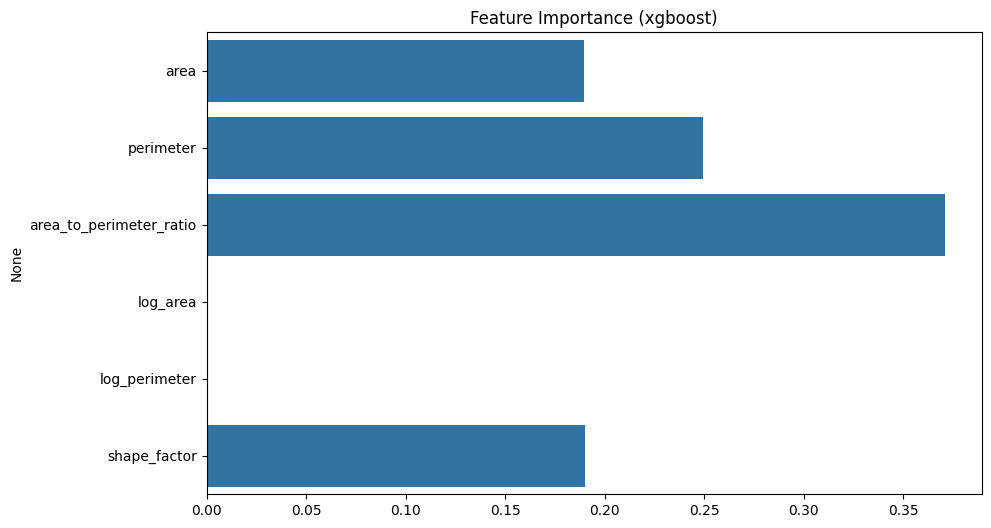


Starting user interface...

1. Enter a state
2. Enter coordinates
3. Exit
Choose an option: 1
Enter state name: Gujrat

Gujrat Performance:
Accuracy: 0.9932
Precision: 0.9932
Recall: 1.0000
F1 Score: 0.9966


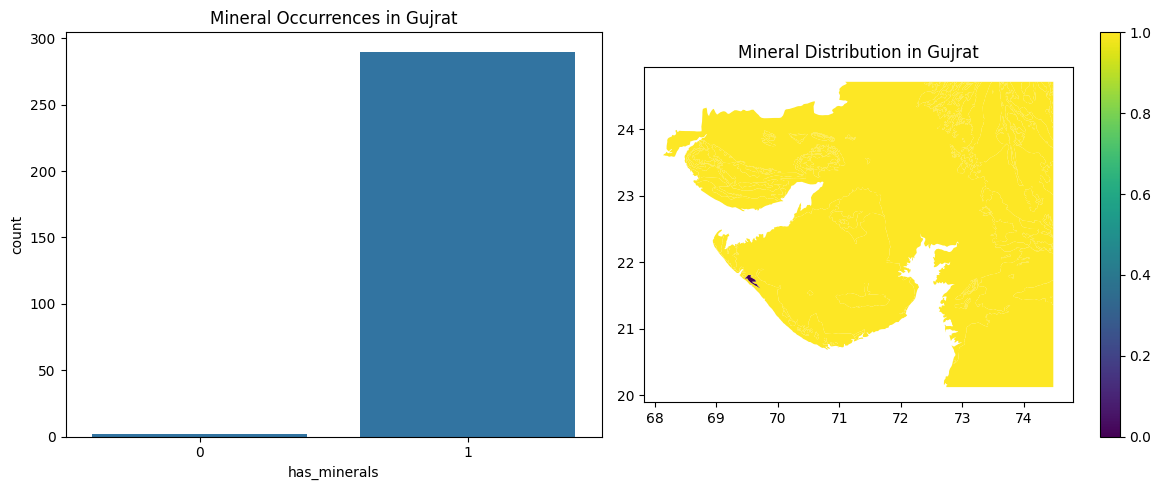


1. Enter a state
2. Enter coordinates
3. Exit
Choose an option: 2
Enter latitude: 1000
Enter longitude: 200
Coordinates not within any known geological area.

1. Enter a state
2. Enter coordinates
3. Exit
Choose an option: 2
Enter latitude: 19.0760
Enter longitude: 72.8777


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Mineral found
Probability of mineral occurrence: 0.84

1. Enter a state
2. Enter coordinates
3. Exit
Choose an option: 1
Enter state name: Goa

Goa Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


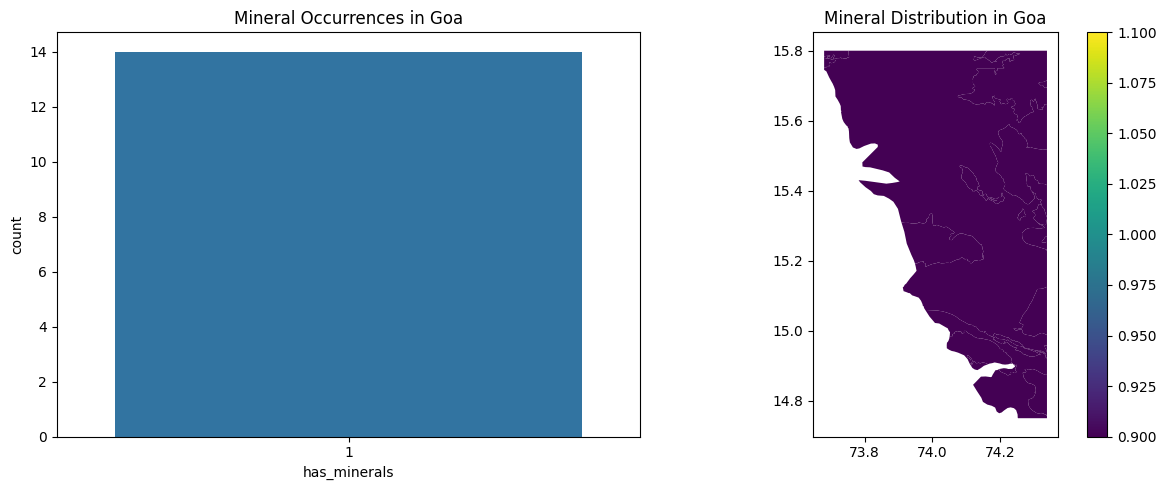


1. Enter a state
2. Enter coordinates
3. Exit
Choose an option: Haryana
Invalid choice. Please try again.

1. Enter a state
2. Enter coordinates
3. Exit
Choose an option: 1
Enter state name: Haryana

Haryana Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


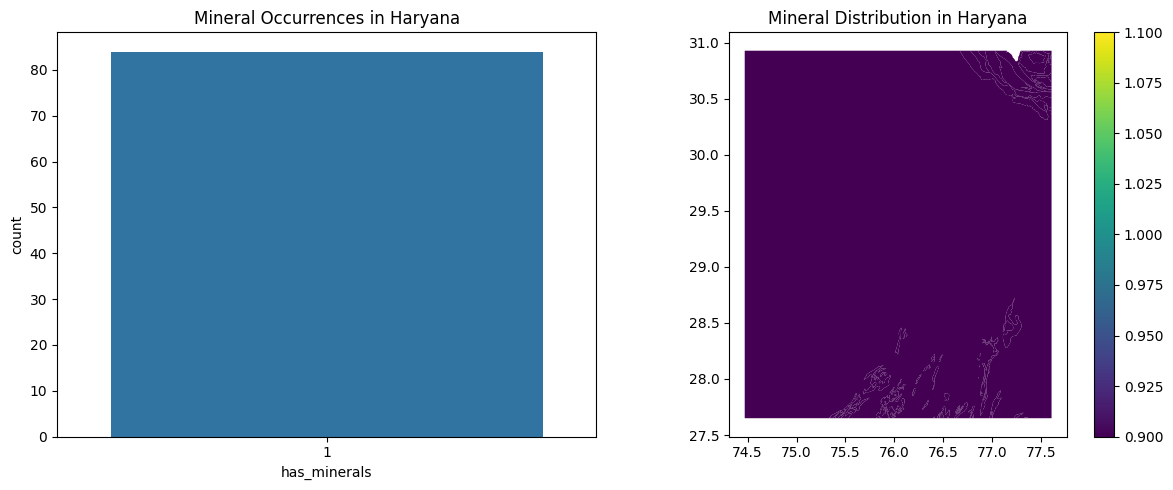


1. Enter a state
2. Enter coordinates
3. Exit
Choose an option: 2
Enter latitude: 19.0760
Enter longitude: 72.8777


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Mineral found
Probability of mineral occurrence: 0.84

1. Enter a state
2. Enter coordinates
3. Exit
Choose an option: 2
Enter latitude: 72.8777
Enter longitude: 19.0760
Coordinates not within any known geological area.

1. Enter a state
2. Enter coordinates
3. Exit
Choose an option: 2
Enter latitude: 72.8777
Enter longitude: 19.0760
Coordinates not within any known geological area.

1. Enter a state
2. Enter coordinates
3. Exit


KeyboardInterrupt: Interrupted by user

In [9]:
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point

def load_and_preprocess_data(states):
    combined_data = pd.DataFrame()
    for state in states:
        geological_file = f"/content/drive/MyDrive/NFC/{state}/Geology 2M.shp"
        mineral_file = f"/content/drive/MyDrive/NFC/{state}/Mineralization.shp"

        gdf_geological = gpd.read_file(geological_file)
        gdf_mineral = gpd.read_file(mineral_file)

        gdf_geological = gdf_geological.dropna()
        gdf_mineral = gdf_mineral.dropna()

        gdf_geological.set_crs(epsg=4326, inplace=True)
        gdf_mineral.set_crs(epsg=4326, inplace=True)
        gdf_geological = gdf_geological.to_crs('EPSG:4326')
        gdf_mineral = gdf_mineral.to_crs('EPSG:4326')

        gdf_geological['area'] = gdf_geological.geometry.area
        gdf_geological['perimeter'] = gdf_geological.geometry.length

        gdf_joined = gpd.sjoin(gdf_mineral, gdf_geological, how="inner", op='within')
        gdf_geological['has_minerals'] = gdf_geological.index.isin(gdf_joined.index).astype(int)

        gdf_geological['state'] = state
        combined_data = pd.concat([combined_data, gdf_geological], ignore_index=True)

    return combined_data

def feature_engineering(data):
    data['area_to_perimeter_ratio'] = data['area'] / data['perimeter']
    data['log_area'] = np.log1p(data['area'])
    data['log_perimeter'] = np.log1p(data['perimeter'])
    data['shape_factor'] = 4 * np.pi * data['area'] / (data['perimeter'] ** 2)
    return data

def train_and_evaluate_model(X_train, X_test, y_train, y_test, model_type='xgboost'):
    if model_type == 'xgboost':
        model = XGBClassifier(random_state=42)
        param_grid = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.3],
            'max_depth': [3, 5, 7]
        }
    elif model_type == 'random_forest':
        model = RandomForestClassifier(random_state=42)
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [5, 10, None],
            'min_samples_split': [2, 5, 10]
        }
    elif model_type == 'lightgbm':
        model = LGBMClassifier(random_state=42)
        param_grid = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.3],
            'num_leaves': [31, 63, 127]
        }
    elif model_type == 'hist_gradient_boosting':
        model = HistGradientBoostingClassifier(random_state=42)
        param_grid = {
            'max_iter': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.3],
            'max_depth': [3, 5, 7]
        }
    elif model_type == 'logistic_regression':
        model = LogisticRegression(random_state=42)
        param_grid = {
            'C': [0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        }

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n{model_type.upper()} Results:")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return best_model, accuracy

def get_state_details(state, combined_data, best_model, scaler):
    state_data = combined_data[combined_data['state'] == state]
    state_X = scaler.transform(state_data[['area', 'perimeter', 'area_to_perimeter_ratio', 'log_area', 'log_perimeter', 'shape_factor']])
    state_y = state_data['has_minerals']
    state_pred = best_model.predict(state_X)

    accuracy = accuracy_score(state_y, state_pred)
    precision = precision_score(state_y, state_pred)
    recall = recall_score(state_y, state_pred)
    f1 = f1_score(state_y, state_pred)

    print(f"\n{state} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Visualizations
    plt.figure(figsize=(12, 5))

    plt.subplot(121)
    sns.countplot(x='has_minerals', data=state_data)
    plt.title(f"Mineral Occurrences in {state}")

    plt.subplot(122)
    state_data.plot(column='has_minerals', cmap='viridis', legend=True, ax=plt.gca())
    plt.title(f"Mineral Distribution in {state}")

    plt.tight_layout()
    plt.show()

def predict_mineral_occurrence(lat, lon, combined_data, best_model, scaler):
    point = Point(lon, lat)
    for _, polygon in combined_data.iterrows():
        if polygon.geometry.contains(point):
            features = polygon[['area', 'perimeter', 'area_to_perimeter_ratio', 'log_area', 'log_perimeter', 'shape_factor']]
            features_scaled = scaler.transform(features.values.reshape(1, -1))
            prediction = best_model.predict(features_scaled)
            probability = best_model.predict_proba(features_scaled)[0][1]
            return prediction[0], probability
    return None, None

def user_interface(combined_data, best_model, scaler, states):
    while True:
        print("\n1. Enter a state")
        print("2. Enter coordinates")
        print("3. Exit")
        choice = input("Choose an option: ")

        if choice == '1':
            state = input("Enter state name: ")
            if state in states:
                get_state_details(state, combined_data, best_model, scaler)
            else:
                print("Invalid state name. Please try again.")

        elif choice == '2':
            lat = float(input("Enter latitude: "))
            lon = float(input("Enter longitude: "))
            prediction, probability = predict_mineral_occurrence(lat, lon, combined_data, best_model, scaler)
            if prediction is not None:
                print(f"Mineral {'found' if prediction == 1 else 'not found'}")
                print(f"Probability of mineral occurrence: {probability:.2f}")
            else:
                print("Coordinates not within any known geological area.")

        elif choice == '3':
            break

        else:
            print("Invalid choice. Please try again.")

def main():
    # Define states
    states = ["Maharashta", "Arunachal pradesh", "Assam","Andhrapradesh","Bihar","Chandigarh","Chhattisgarh","Goa","Gujrat","Haryana","Himachal Pradesh","Jammu and Kashmir","Jharkhand","Karnataka","Ladakh","Madhya Pradesh","Manipur","Meghalaya","Mizoram","Nagaland","Odisha","Puducherry","Punjab","Rajasthan","Sikkim","Tamil Nadu","Telangana","Tripura","Uttar Pradesh","Uttarakhand","West Bengal"]

    # Load and preprocess data
    print("Loading and preprocessing data...")
    combined_data = load_and_preprocess_data(states)
    combined_data = feature_engineering(combined_data)

    # Prepare features and target
    X = combined_data[['area', 'perimeter', 'area_to_perimeter_ratio', 'log_area', 'log_perimeter', 'shape_factor']]
    y = combined_data['has_minerals']

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

    # Train and evaluate models
    models = ['xgboost', 'random_forest', 'lightgbm', 'hist_gradient_boosting', 'logistic_regression']

    best_model = None
    best_accuracy = 0
    best_model_name = ''

    print("Training and evaluating models...")
    for model_type in models:
        model, accuracy = train_and_evaluate_model(X_train, X_test, y_train, y_test, model_type=model_type)
        if accuracy > best_accuracy:
            best_model = model
            best_accuracy = accuracy
            best_model_name = model_type

    print(f"\nBest Model: {best_model_name}")
    print(f"Best Accuracy: {best_accuracy:.4f}")

    # Feature importance for the best performing model (except for logistic regression)
    if best_model_name != 'logistic_regression':
        feature_importance = best_model.feature_importances_
        feature_names = X.columns

        plt.figure(figsize=(10, 6))
        sns.barplot(x=feature_importance, y=feature_names)
        plt.title(f"Feature Importance ({best_model_name})")
        plt.show()
    else:
        # For logistic regression, we can plot the coefficients
        coefficients = best_model.coef_[0]
        feature_names = X.columns

        plt.figure(figsize=(10, 6))
        sns.barplot(x=coefficients, y=feature_names)
        plt.title("Feature Coefficients (Logistic Regression)")
        plt.show()

    # Start user interface
    print("\nStarting user interface...")
    user_interface(combined_data, best_model, scaler, states)

if __name__ == "__main__":
    main()